In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
import cv2
import random
import string


In [2]:
# Utility functions
def preprocess(img):
    img = img[:84, 6:90]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [3]:
def animate(imgs, video_name, _return=True):
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [4]:
def evaluate(agent, n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    scores = 0
    for _ in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

In [5]:
# ImageEnv Wrapper
class ImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=4, stack_frames=4, initial_no_op=50, **kwargs):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        s, info = self.env.reset()
        for _ in range(self.initial_no_op):
            s, _, terminated, truncated, _ = self.env.step(0)
            if terminated or truncated:
                s, info = self.env.reset()
        s = preprocess(s)
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info

    def step(self, action):
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break
        s = preprocess(s)
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)
        return self.stacked_state, reward, terminated, truncated, info

In [6]:
# CNNActionValue class
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# ReplayBuffer class
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)
        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (torch.FloatTensor(self.s[ind]), torch.FloatTensor(self.a[ind]), 
                torch.FloatTensor(self.r[ind]), torch.FloatTensor(self.s_prime[ind]), 
                torch.FloatTensor(self.terminated[ind]))

In [8]:
# DQN class
class DQN:
    def __init__(self, state_dim, action_dim, lr=0.00025, epsilon=1.0, epsilon_min=0.1, gamma=0.99, batch_size=32,
                 warmup_steps=5000, buffer_size=int(1e5), target_update_interval=10000):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval
        self.total_steps = 0

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)
        self.buffer = ReplayBuffer(state_dim, (1,), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)

    @torch.no_grad()
    def act(self, x, training=True):
        self.network.train(training)
        if training and (np.random.rand() < self.epsilon or self.total_steps < self.warmup_steps):
            return np.random.randint(0, self.action_dim)
        x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
        return torch.argmax(self.network(x)).item()

    def learn(self):
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        next_q = self.target_network(s_prime).detach()
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {'total_steps': self.total_steps, 'value_loss': loss.item()}

    def process(self, transition):
        self.total_steps += 1
        self.buffer.update(*transition)
        if self.total_steps > self.warmup_steps:
            result = self.learn()
        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
        return result if self.total_steps > self.warmup_steps else {}

In [9]:
# Initialize environment and agent
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim)

max_steps = 1e6#int(2e6)
eval_interval = 10000

history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()

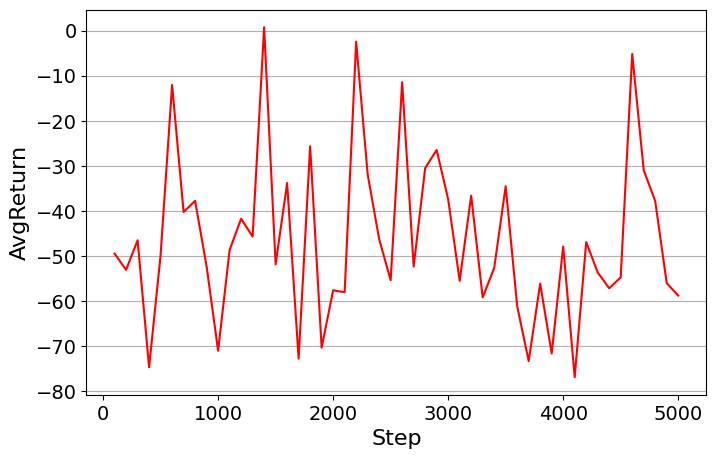

In [10]:
#training
while agent.total_steps <= max_steps:
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
    if agent.total_steps % eval_interval == 0:
        ret = evaluate(agent)
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        torch.save(agent.network.state_dict(), 'dqn.pt')

In [12]:
# Final evaluation and animation
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, _ = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated

animate(frames, 'animation.webm')

In [12]:
# Load model function
def load_model(agent, model_path):
    agent.network.load_state_dict(torch.load(model_path))
    agent.target_network.load_state_dict(agent.network.state_dict())

In [13]:
# Initialize environment and agent
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim)

# Load the model if it exists
model_path = 'dqn.pt'
try:
    load_model(agent, model_path)
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Model file not found. Training from scratch.")

Model loaded successfully.


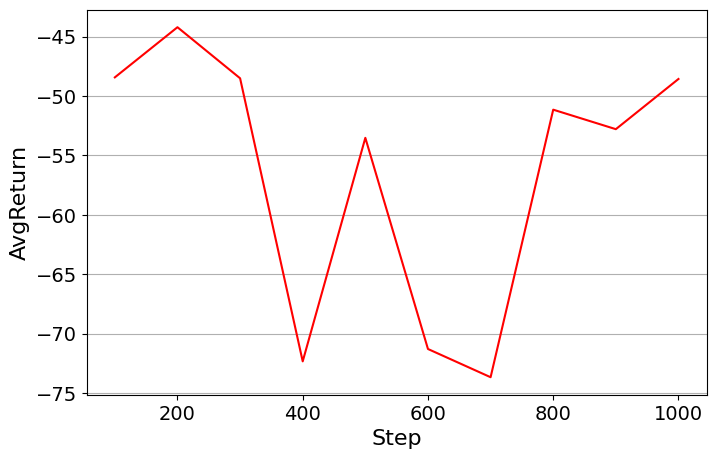

In [14]:
# continue training
max_steps = 1e6#int(2e6)
eval_interval = 10000

history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()
while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()

    if agent.total_steps % eval_interval == 0:
        ret = evaluate(agent)
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        torch.save(agent.network.state_dict(), model_path)

    if agent.total_steps > max_steps:
        break


In [15]:
# Final evaluation and animation
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, _ = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated

animate(frames, 'animation.webm')